# **08 Predictive model**

## Objectives

* Build the baseline predictive model

## Inputs

* housing_cleaned.csv

## Outputs

* test_set.csv


---

# Baseline model

Import packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 


In [4]:
# read in the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned-geo.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7249 entries, 0 to 7248
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transaction                   7248 non-null   object 
 1   price                         7248 non-null   float64
 2   transfer_date                 7248 non-null   object 
 3   postcode                      7248 non-null   object 
 4   property_type                 7248 non-null   object 
 5   new_build                     7248 non-null   float64
 6   tenure                        7248 non-null   object 
 7   PAON                          7248 non-null   object 
 8   SAON                          371 non-null    object 
 9   Street                        7219 non-null   object 
 10  Locality                      3020 non-null   object 
 11  town_city                     7248 non-null   object 
 12  district                      7248 non-null   object 
 13  cou

---

The ruc21 values refer to the Rural Urban Classification (RUC) codes which categorize each area as urban or rural based on population and settlement characteristics. Examples from your data include UNI, RUN1, RSNI, UF1, etc.

- UN1: Urban city and town
- RLN1: Rural town and fringe
- RSN1: Rural village
- UF1: Urban major conurbation
- RLF1: Rural hamlet and isolated dwellings
- RSF1: Rural hamlet and isolated dwellings in a sparse setting

In [6]:
df['ruc21'].value_counts()

ruc21
UN1     5888
RLN1     622
RSN1     469
UF1      131
RLF1      70
RSF1      68
Name: count, dtype: int64

In [7]:
# convert to datetime
df['transfer_date'] = pd.to_datetime(df['transfer_date'])
# keep only the transfer_date for 2024 onwards
df = df[df['transfer_date'].dt.year >= 2024]

In [8]:
# set model features
num_feats   = ['log_total_floor_area','IMD_Rank','energy_band_num']
bin_feats   = ['new_build','is_leasehold']  # pass through as 0/1
cat_feats   = ['property_type','county','ruc21']  # one-hot encode

# Control category order to set baselines via drop='first'
ptype_order = ['D','S','T','F']  # baseline becomes 'D' (Detached)
county_order = [
    'WEST MIDLANDS','WARWICKSHIRE','WORCESTERSHIRE','LEICESTERSHIRE',
    'LEICESTER','STAFFORDSHIRE','DERBYSHIRE','CITY OF DERBY','STOKE-ON-TRENT'
]  # baseline becomes WEST MIDLANDS
ruc21_order = ['UN1','UF1','RLN1','RSN1','RLF1','RSF1']  # baseline becomes UN1 (Urban city and town)

# Build the ColumnTransformer (code suggested by Copilot)
pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first',
                              categories=[ptype_order, county_order, ruc21_order],
                              handle_unknown='ignore'),
         cat_feats),
        ('bin', 'passthrough', bin_feats),
    ],
    remainder='drop'
)

# End-to-end pipeline
pipeline = Pipeline([
    ('pre', pre),
    ('model', LinearRegression()) # or Ridge(alpha=1.0)
])


X = df[num_feats + cat_feats + bin_feats]
y = df['log_price']  # log price to reduce skew

# Test using the most recent 20% of the data as the test set
# Use a sorted split based on date
df = df.sort_values(by='transfer_date').reset_index(drop=True)
# split index at 80%
split_index = int(len(df) * 0.8)
print(f"Split index: {split_index}, Total records: {len(df)}")
print(f"Date at split index: {df.iloc[split_index]['transfer_date']}")

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# separate target variable
y_train = train_df['log_price']
y_test = test_df['log_price']
X_train = train_df.drop(columns=['log_price'])
X_test = test_df.drop(columns=['log_price'])

# fit the pipeline
pipeline.fit(X_train, y_train)


Split index: 5667, Total records: 7084
Date at split index: 2025-08-01 00:00:00


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_total_floor_area',
                                                   'IMD_Rank',
                                                   'energy_band_num']),
                                                 ('cat',
                                                  OneHotEncoder(categories=[['D',
                                                                             'S',
                                                                             'T',
                                                                             'F'],
                                                                            ['WEST '
                                                                             'MIDLANDS',
                                                                             'WARWICKSHIRE',
                                                                             'WORCESTERSHIRE',
                                                                             'LEICESTERSHIRE',
                                                                             'LEICESTER',
                                                                             'STAFFORDSHIRE',
                                                                             'DERBYSHIRE',
                                                                             'CITY '
                                                                             'OF '
                                                                             'DERBY',
                                                                             'STOKE-ON-TRENT'],
                                                                            ['UN1',
                                                                             'UF1',
                                                                             'RLN1',
                                                                             'RSN1',
                                                                             'RLF1',
                                                                             'RSF1']],
                                                                drop='first',
                                                                handle_unknown='ignore'),
                                                  ['property_type', 'county',
                                                   'ruc21']),
                                                 ('bin', 'passthrough',
                                                  ['new_build',
                                                   'is_leasehold'])])),
                ('model', LinearRegression())])

### Note:
- The following are custom functions to evaluate regression models.
- These were provided by the Code Institute for their Data Analysis with AI course.

In [9]:
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Gets train/test sets and pipeline and evaluates the performance
    for each set (train and test) by calling regression_evaluation()
    which will evaluate the pipeline performance.

    Parameters:
    - X_train: The input features of the training set.
    - y_train: The target values of the training set.
    - X_test: The input features of the test set.
    - y_test: The target values of the test set.
    - pipeline: The regression pipeline to evaluate.

    Returns:
    None
    """

    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    """
    Gets features and target (either from train or test set) and pipeline.
    
    Args:
        X (array-like): The input features.
        y (array-like): The target values.
        pipeline (object): The trained pipeline for regression.
    
    Returns:
        None
    
    Prints the following performance metrics comparing the prediction to the target:
    - R2 Score
    - Mean Absolute Error
    - Mean Squared Error
    - Root Mean Squared Error
    """
    prediction = pipeline.predict(X)
    print("R2 Score:", r2_score(y, prediction).round(3))
    print("Mean Absolute Error:", mean_absolute_error(y, prediction).round(3))
    print("Mean Squared Error:", mean_squared_error(y, prediction).round(3))
    print(
        "Root Mean Squared Error:", np.sqrt(mean_squared_error(y, prediction)).round(3)
    )
    print("\n")


Regression Model Performance 
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.698
Mean Absolute Error: 0.182
Mean Squared Error: 0.059
Root Mean Squared Error: 0.243


* Test Set
R2 Score: 0.737
Mean Absolute Error: 0.178
Mean Squared Error: 0.056
Root Mean Squared Error: 0.236


The train set Mean Absolute Error in GBP: 50,535
The test  set Mean Absolute Error in GBP: 50,148


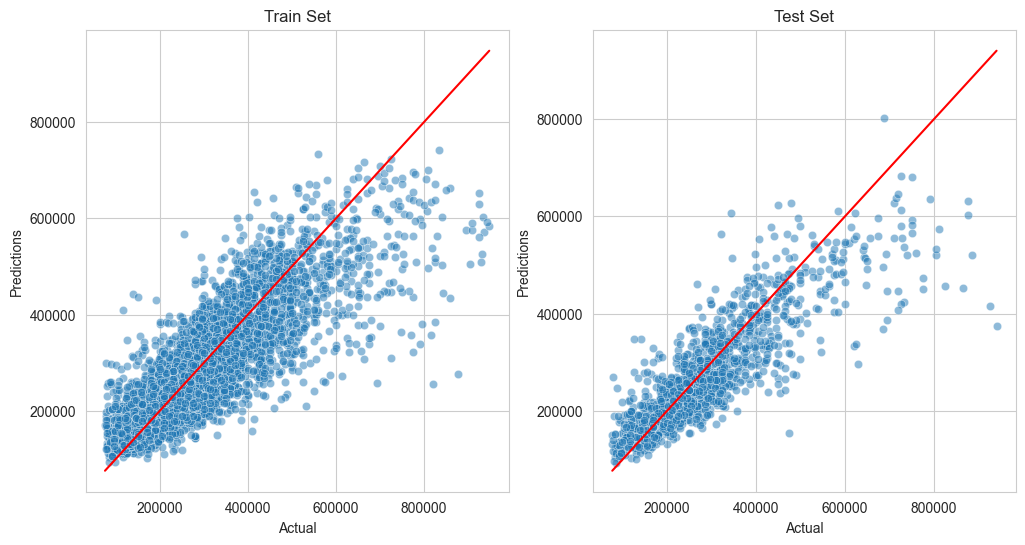

In [10]:
print("Regression Model Performance \nNote the MAE and MSE are in log(GBP) not GBP")
regression_performance(X_train, y_train, X_test, y_test, pipeline)

alpha_scatter=0.5
# change the actuals and predictions to GBP
y_train_gbp = np.expm1(y_train)
y_test_gbp = np.expm1(y_test)
y_pred_gbp = np.expm1(pipeline.predict(X_test))
y_pred_train = np.expm1(pipeline.predict(X_train))

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae_test:,.0f}")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.scatterplot(x=y_train_gbp, y=y_pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train_gbp, y=y_train_gbp, color="red", ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test_gbp, y=y_pred_gbp, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test_gbp, y=y_test_gbp, color="red", ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.show()


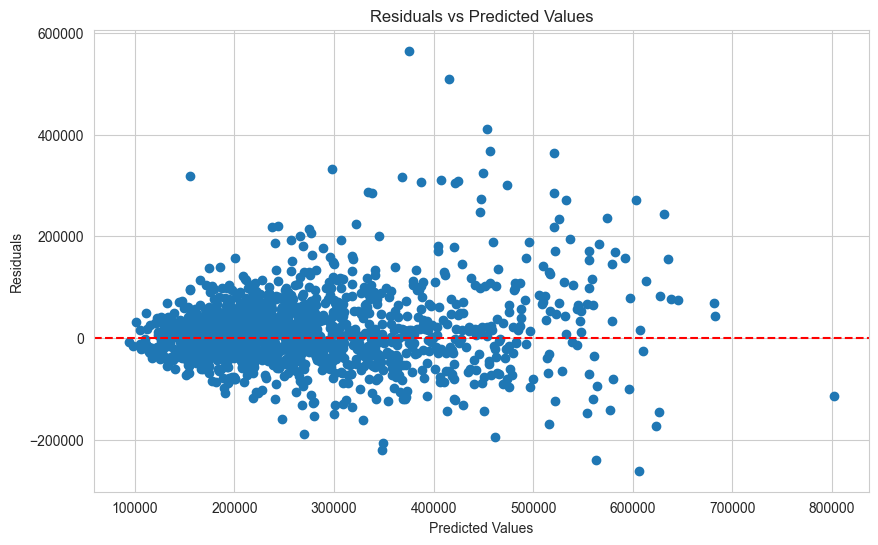

In [11]:
# plot the residuals
residuals = y_test_gbp - y_pred_gbp
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gbp, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

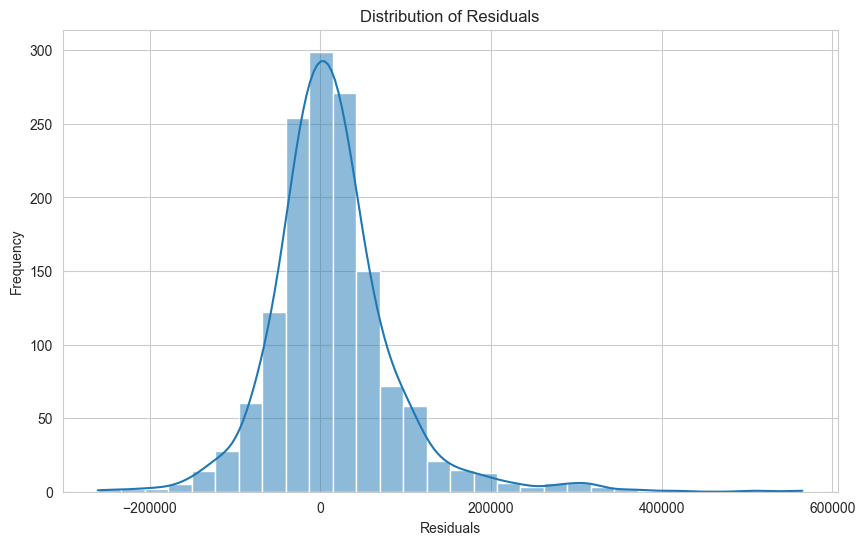

In [12]:
# what is the distribution of the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Save in a csv for analysis in Tableau
# merge X_train, X_test, y_train_gbp and y_test_gbp into a single dataframe
to_save = pd.concat([X_train, X_test], axis=0)
predicted_price = pd.concat([
    pd.Series(y_pred_train, name="predicted_price"),
    pd.Series(y_pred_gbp, name="predicted_price")
], axis=0)
to_save = pd.concat([
    to_save.reset_index(drop=True), 
    predicted_price.reset_index(drop=True), 
], axis=1)
# rename columns
to_save = to_save.rename(columns={"y_train_gbp": "actual_price_gbp", "y_test_gbp": "actual_price_gbp", "y_pred_train": "predicted_price_gbp", "y_pred_gbp": "predicted_price_gbp"})




In [ ]:
# fix the is_leasehold and is_flat columns to be boolean
to_save['is_leasehold'] = to_save['tenure']=='L'
to_save['is_flat'] = to_save['property_type']=='F'
# is_flat_leasehold
to_save['is_flat_leasehold'] = to_save['is_flat'] & to_save['is_leasehold']

# drop columns with all missing values
to_save = to_save.dropna(axis=1, how='all')

# Save the full set for testing with other models

In [ ]:
to_save.to_csv('../data/processed/test_set.csv', index=False)

In [14]:
import joblib
joblib.dump(value=pipeline , filename="baseline_model.pkl")

['baseline_model.pkl']

### Conclusions 
- The performance on the train and test set is similar, indicating that the model is not overfitting.
- The R2 values are 0.70 respectively 0.74, which is good for a baseline model.
- We also note in the plots of Prediction x Actual, the predictions tend to follow the actual value. 
- The residuals distribution is approximately normal, centered around zero, with slight skew and some outliers in both tails.